# Causal inference R
Let's do some causal inference in R to determine effect of "treatment" (landfall/no). We've already organized the data [here](pre_post_landfall_comparison.ipynb#Causal-inference).

In [1]:
require(data.table)
# data <- read.table('../../data/mined_tweets/combined_tweet_NE_landfall_treatment.tsv', sep='\t', header = TRUE)
data <- as.data.frame(fread('../../data/mined_tweets/combined_tweet_NE_landfall_treatment.tsv'))

Loading required package: data.table


In [72]:
library('dplyr')
head(data)
# count unique # samples from each dataset
data %>%
    group_by(data_name_fixed) %>%
    count()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



username_fixed,user_activity,user_activity_bin,data_name_fixed,id,txt,username,date,lang,NE,⋯,max_names_bin,username_rt,followers_count,friends_count,followers_log,friends_log,followers_friends,landfall_diff,NE_fixed_data_name,landfall_treatment
BMcNoldy,2.70805,2,harvey,2.342112e-248,"SOME good news: although #Harvey 's center is now on the coastline again, dry air is mixing into the circulation, choking off some rainbands. <URL>",BMcNoldy,1503916260,en,center,⋯,1,,6046,1586,8.707318,7.369601,1.337717,2,center_harvey,1
BMcNoldy,2.70805,2,harvey,1.978085e-248,"#Harvey left Africa 13 days ago, then named 8 days ago. Who would have guessed it would be a Cat 3-4 hurricane slamming into Corpus Christi?",BMcNoldy,1503697620,en,Corpus_Christi,⋯,0,,6046,1586,8.707318,7.369601,1.337717,-1,corpus_christi_harvey,0
BMcNoldy,2.70805,2,harvey,1.978085e-248,"#Harvey left Africa 13 days ago, then named 8 days ago. Who would have guessed it would be a Cat 3-4 hurricane slamming into Corpus Christi?",BMcNoldy,1503697620,en,Africa,⋯,0,,6046,1586,8.707318,7.369601,1.337717,-1,africa_harvey,0
BMcNoldy,2.70805,2,harvey,2.367674e-248,"Tropical Storm #Harvey moving back over water, new wave emerging from Africa. <URL>",BMcNoldy,1503931620,en,Africa,⋯,0,,6046,1586,8.707318,7.369601,1.337717,2,africa_harvey,1
BMcNoldy,2.70805,2,harvey,1.993328e-248,Sunset on The Beast. #Harvey <URL>,BMcNoldy,1503706740,en,Sunset,⋯,1,,6046,1586,8.707318,7.369601,1.337717,-1,sunset_harvey,0
BMcNoldy,2.70805,2,harvey,2.017035e-248,RT @BMcNoldy: Sunset on The Beast. #Harvey <URL>,tomgillpredicts,1503721031,en,Sunset,⋯,1,BMcNoldy,6046,1586,8.707318,7.369601,1.337717,0,sunset_harvey,0


data_name_fixed,n
florence,4797
harvey,21819
irma,31306
maria,1686
michael,4548


### Causal inference with matching
Let's try to match each treatment sample with a control using [matching algorithm](https://www.rdocumentation.org/packages/MatchIt/versions/3.0.2/topics/matchit).

In [3]:
library('MatchIt')

In [ ]:
covars <- c('max_population', 'max_alternate_name_count', 'user_activity', 'followers_log', 'followers_friends')
treatment_var <- 'landfall_treatment'
out_var <- 'max_population_anchor'
all_vars <- c(covars, treatment_var, out_var)
formula <- as.formula(paste(treatment_var, paste(covars, collapse = ' + '), sep=' ~ '))
# reverse treatment?? because matching assumes more control than treatment
data_tmp <- copy(data)
data_tmp[, treatment_var] <- 1 - data_tmp[, treatment_var]
print(formula)
match_results <- matchit(formula, data=data_tmp[, all_vars], method='nearest')

landfall_treatment ~ max_population + max_alternate_name_count + 
    user_activity + followers_log + followers_friends



Call:
matchit(formula = formula, data = data_tmp[, all_vars], method = "nearest")

Summary of balance for all data:
                         Means Treated Means Control  SD Control    Mean Diff
distance                        0.2418        0.2291      0.0468       0.0127
max_population             469674.4590   633441.7572 951371.9187 -163767.2983
max_alternate_name_count       28.0820       32.4127     19.6489      -4.3307
user_activity                   2.5518        2.3667      1.5490       0.1852
followers_log                   8.2111        7.9847      2.4672       0.2264
followers_friends               1.4063        1.1984      2.2531       0.2079
                            eQQ Med    eQQ Mean      eQQ Max
distance                     0.0128      0.0127       0.0574
max_population           41794.0000 163813.4374 3466913.0000
max_alternate_name_count     4.0000      4.3609      23.0000
user_activity                0.2513      0.2558       1.2291
followers_log                0.2

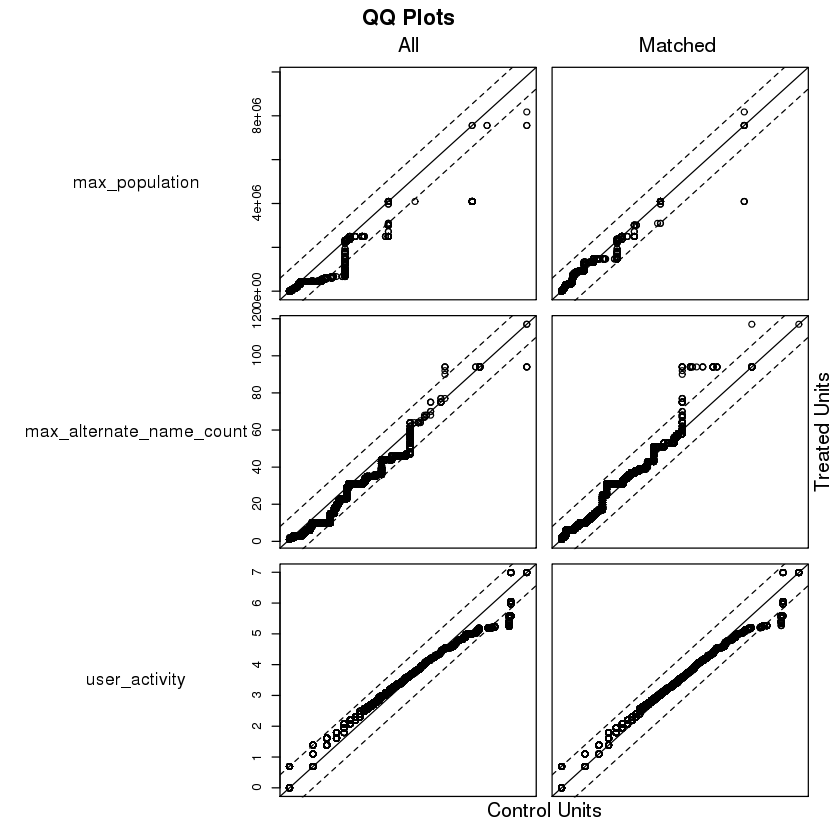

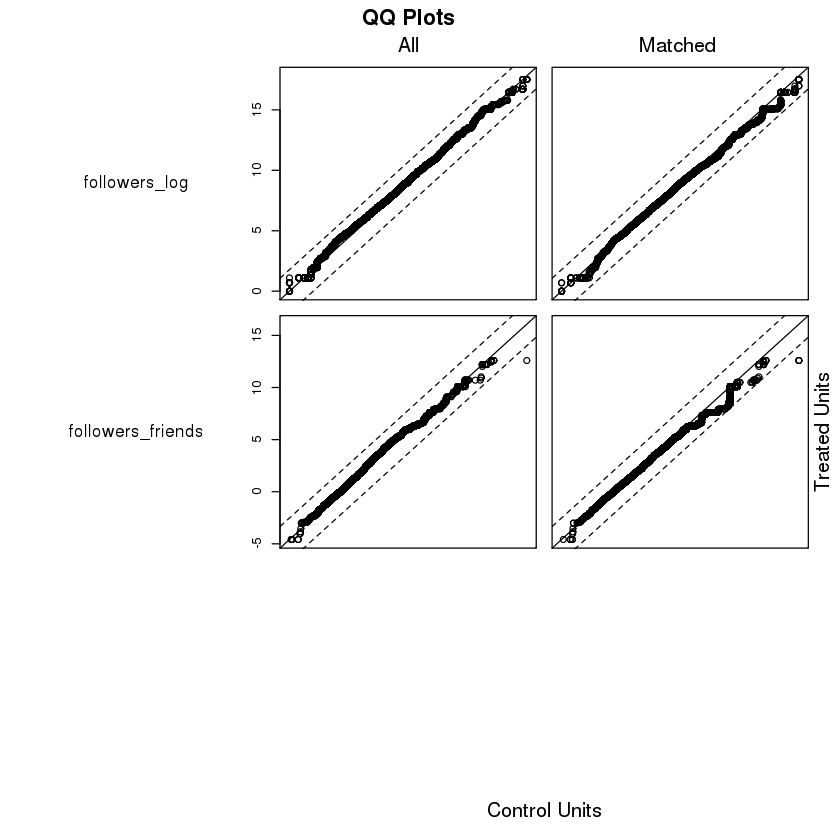

In [16]:
summary(match_results)
plot(match_results)

Let's use these matches and compute the treatment effect!!

In [17]:
# restrict to matched units
match_data <- match.data(match_results)

In [59]:
# switch treatment/control back to normal
match_data[, treatment_var] <- 1 - match_data[, treatment_var]

In [60]:
# .libPaths()
# install.packages('Zelig', repos='http://cran.us.r-project.org')
library('Zelig')

In [61]:
covars <- c('max_population', 'max_alternate_name_count', 'user_activity', 'followers_log', 'followers_friends')
treatment_var <- 'landfall_treatment'
out_var <- 'max_population_anchor'
formula <- as.formula(paste(out_var, paste(c(covars, treatment_var), collapse = ' + '), sep=' ~ '))
z_out <- zelig(formula, data=match_data, model='ls')

How to cite this model in Zelig:
  R Core Team. 2007.
  ls: Least Squares Regression for Continuous Dependent Variables
  in Christine Choirat, Christopher Gandrud, James Honaker, Kosuke Imai, Gary King, and Olivia Lau,
  "Zelig: Everyone's Statistical Software," http://zeligproject.org/


In [62]:
summary(z_out)

Model: 

Call:
z5$zelig(formula = formula, data = match_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5856 -0.3552 -0.2380  0.5675  1.2118 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)
(Intercept)               3.530e-01  1.371e-02  25.749  < 2e-16
max_population           -6.377e-08  4.629e-09 -13.776  < 2e-16
max_alternate_name_count -3.132e-03  1.881e-04 -16.653  < 2e-16
user_activity             3.102e-02  1.920e-03  16.157  < 2e-16
followers_log             2.493e-03  1.781e-03   1.400    0.162
followers_friends        -5.710e-04  1.844e-03  -0.310    0.757
landfall_treatment       -2.707e-02  5.248e-03  -5.157 2.52e-07

Residual standard error: 0.4523 on 29773 degrees of freedom
Multiple R-squared:  0.05944,	Adjusted R-squared:  0.05925 
F-statistic: 313.6 on 6 and 29773 DF,  p-value: < 2.2e-16

Next step: Use 'setx' method


In [63]:
## compute means for covariates
x_out <- setx(z_out, landfall_treatment=0)
x1_out <- setx(z_out, landfall_treatment=1)
s_out <- sim(z_out, x=x_out, x1=x1_out)
summary(s_out)


 sim x :
 -----
ev
       mean          sd       50%      2.5%     97.5%
1 0.3334061 0.003786732 0.3334443 0.3260206 0.3405664
pv
          mean        sd       50%       2.5%    97.5%
[1,] 0.3214074 0.4570125 0.3081145 -0.5457519 1.259806

 sim x1 :
 -----
ev
       mean          sd       50%      2.5%     97.5%
1 0.3060341 0.003826523 0.3060914 0.2986567 0.3134286
pv
          mean        sd       50%       2.5%   97.5%
[1,] 0.2892332 0.4545138 0.2871884 -0.6256607 1.18904
fd
         mean         sd         50%        2.5%       97.5%
1 -0.02737203 0.00543408 -0.02741614 -0.03806115 -0.01698884


In [65]:
names(s_out)

[1] "range1"               "model.call"           "originaldata"        
 [4] "initialize"           "zelig.out"            "range"               
 [7] "mi"                   "bsetrange"            "show"                
[10] "robust.se"            "simx1"                "setx.out"            
[13] "initialize#Zelig"     "modelauthors"         "formula"             
[16] "url.docs"             "acceptweights"        "mcformula"           
[19] "graph"                "year"                 "get_names"           
[22] "originalweights"      "vignette.url"         "bootstrap.num"       
[25] "test.statistics"      "by"                   "mcunit.test"         
[28] "simx"                 "param"                "refs"                
[31] "signif.stars.default" "explanatory"          "setforeveryby"       
[34] "weights"              "avg"                  "signif.stars"        
[37] "get_qi"               "wrapper"              "bsetx"               
[40] "with.feedback"        "authors"              "simparam"            
[43] "url"                  "category"             "qi"                  
[46] "sim.out"              "bsetx1"               "num"                 
[49] "packageauthors"       "matched"              "outcome"             
[52] "bootstrap"            "data"                 "bsetrange1"          
[55] "zelig.call"           "idx"                  "summarize"           
[58] "zeligauthors"         "ljson"                "description"         
[61] "sim"                  "setx.labels"          "fn"                  
[64] "name"                 "json"

Can we plot this?

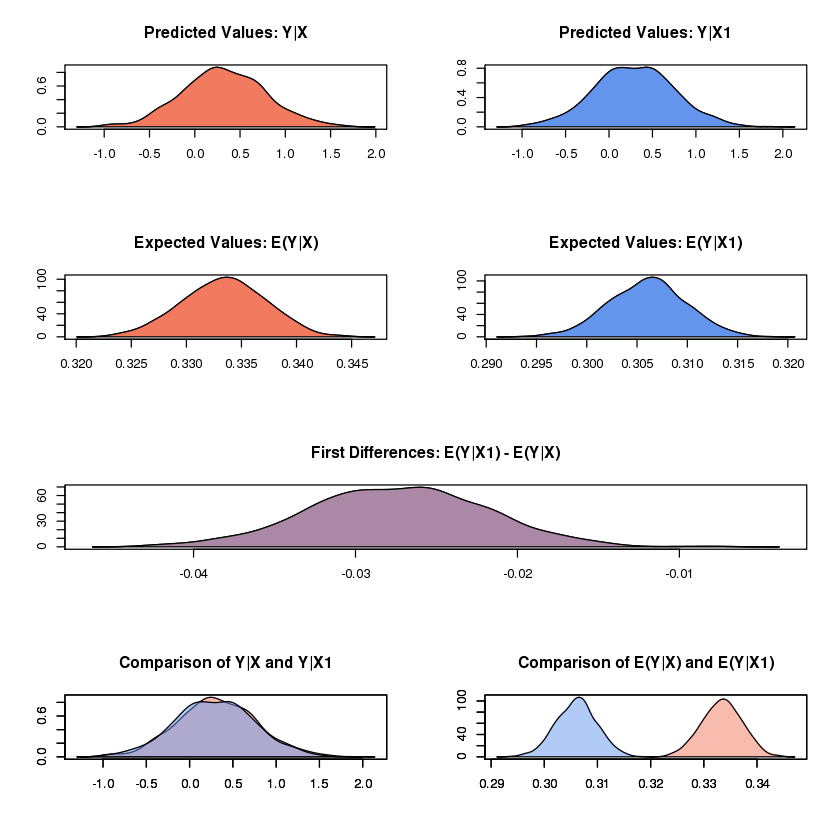

In [64]:
plot(s_out)

What I think this means:

- Since `treatment` (x1) has significantly higher mean than `control` (x) and we had to reverse treatment/control to handle the class imbalance, we can conclude that the **real** treatment effect is negative:
    - after landfall => lower anchor probability
    
This matches our intuition from the earlier match results and the propensity score matching (both in `casualinference.py`).

In [51]:
?sim

In [67]:
## compute ATE
match_data_control <- match.data(match_results, 'control')
match_data_treat <- match.data(match_results, 'treat')
match_data_control[, treatment_var] <- 1 - match_data_control[, treatment_var]
match_data_treat[, treatment_var] <- 1 - match_data_treat[, treatment_var]
covar_formula <- paste(out_var, paste(covars, collapse=' + '), sep = ' ~ ')
z_out1 <- zelig(covar_formula, data=match_data_control, model='ls')
## compute effect on treatment
x_out1 <- setx(z_out1, data = match.data(m_out1, "treat"), cond = TRUE)
s_out1 <- sim(z_out1, x = x_out1)
## compute effect on control
z_out2 <- zelig(covar_formula, data = match_data_treat, model = "ls")
x_out2 <- setx(z_out2, data = match_data_control, cond = TRUE)
s_out2 <- sim(z_out2, x = x_out2)
## compute ATE
print('treatment effect')
summary(s_out1)
print('control effect')
summary(s_out2)
# ate_all <- c(s_out1$qi$att.ev, -s_out2$qi$att.ev)
# print(mean(ate_all))
# print(sd(ate_all))
# print(quantile(ate_all, c(0.025, 0.975)))

How to cite this model in Zelig:
  R Core Team. 2007.
  ls: Least Squares Regression for Continuous Dependent Variables
  in Christine Choirat, Christopher Gandrud, James Honaker, Kosuke Imai, Gary King, and Olivia Lau,
  "Zelig: Everyone's Statistical Software," http://zeligproject.org/
How to cite this model in Zelig:
  R Core Team. 2007.
  ls: Least Squares Regression for Continuous Dependent Variables
  in Christine Choirat, Christopher Gandrud, James Honaker, Kosuke Imai, Gary King, and Olivia Lau,
  "Zelig: Everyone's Statistical Software," http://zeligproject.org/
[1] "treatment effect"

 sim x :
 -----
ev
       mean          sd       50%      2.5%     97.5%
1 0.3053263 0.003571786 0.3053228 0.2985723 0.3123493
pv
          mean        sd       50%       2.5%    97.5%
[1,] 0.2771381 0.4707767 0.2772099 -0.6716689 1.184018
[1] "control effect"

 sim x :
 -----
ev
       mean         sd       50%      2.5%     97.5%
1 0.3340415 0.00366808 0.3340241 0.3273854 0.3414361
pv
        

In [48]:
names(s_out1)
print(s_out1[['setx.out']])

[1] "range1"               "model.call"           "originaldata"        
 [4] "initialize"           "zelig.out"            "range"               
 [7] "mi"                   "bsetrange"            "show"                
[10] "robust.se"            "setx.out"             "initialize#Zelig"    
[13] "modelauthors"         "formula"              "url.docs"            
[16] "acceptweights"        "mcformula"            "year"                
[19] "get_names"            "originalweights"      "vignette.url"        
[22] "bootstrap.num"        "test.statistics"      "by"                  
[25] "mcunit.test"          "simx"                 "param"               
[28] "refs"                 "signif.stars.default" "explanatory"         
[31] "setforeveryby"        "weights"              "avg"                 
[34] "signif.stars"         "wrapper"              "bsetx"               
[37] "with.feedback"        "authors"              "simparam"            
[40] "url"                  "category"             "qi"                  
[43] "sim.out"              "bsetx1"               "num"                 
[46] "packageauthors"       "matched"              "outcome"             
[49] "bootstrap"            "data"                 "bsetrange1"          
[52] "zelig.call"           "idx"                  "summarize"           
[55] "zeligauthors"         "ljson"                "description"         
[58] "sim"                  "setx.labels"          "fn"                  
[61] "name"                 "json"

$x
Source: local data frame [1 x 2]
Groups: <by row>

# A tibble: 1 x 2
     by            mm
* <dbl>        <list>
1     1 <dbl [1 x 6]>



In [22]:
sim_out <- sim(z_out, x=x_out, x1=x1_out)
summary(sim_out)


 sim x :
 -----
ev
       mean          sd      50%      2.5%     97.5%
1 0.3062818 0.003727632 0.306386 0.2987151 0.3132836
pv
          mean        sd       50%       2.5%    97.5%
[1,] 0.3154353 0.4359749 0.3017161 -0.5775529 1.144733

 sim x1 :
 -----
ev
       mean          sd       50%      2.5%     97.5%
1 0.3330352 0.003690237 0.3331504 0.3254821 0.3402747
pv
          mean        sd       50%       2.5%    97.5%
[1,] 0.3107557 0.4477263 0.3299317 -0.5329288 1.165709
fd
       mean          sd        50%       2.5%      97.5%
1 0.0267534 0.005265902 0.02681815 0.01673849 0.03715154


In [ ]:
## add data name as binary covariate? could handle possible higher base probability levels

### Compute ADRF from freq
Let's compute the Average Dose Response Function ([here](https://cran.r-project.org/web/packages/causaldrf/vignettes/Using_causaldrf.pdf)) to determine the approximate effect of prior frequency on anchor probability.

In [1]:
## load complete data

In [2]:
## restrict to valid NEs, freq NEs, etc.

In [3]:
## compute prior frequency for each NE

In [4]:
## re-write ADRF to logistic > OLS regression?? ugh!!

In [5]:
## run ADRF